In [1]:
#import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

from statsmodels.tsa.stattools import adfuller

In [4]:
data = pd.read_csv('/content/cbsl_tot_tax.csv')

In [5]:
data.head()

,Year,Tax Revenue
0,1990,61206.0
1,1991,68157.0
2,1992,76353.0
3,1993,85891.0
4,1994,99417.0


In [7]:
data.dtypes

Year             int64
Tax Revenue    float64
dtype: object

In [8]:
#checking the data types
data.dtypes

#getting the mean of tax revenue ammount and fill it to null, if theres any
data["Tax Revenue"] = data["Tax Revenue"].astype("float64")
m=round(data["Tax Revenue"].mean(),2)
data["Tax Revenue"].fillna(m,inplace=True)

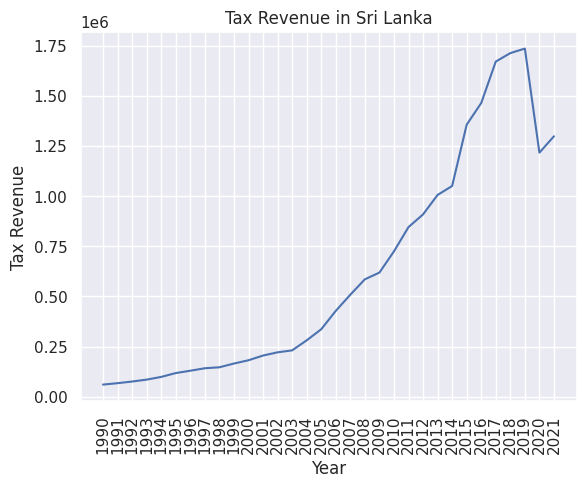

In [9]:
# Compute the number of years in the dataset
num_years = len(data['Year'])

# Set the x-axis ticks to represent each year
x_ticks = range(data['Year'][0], data['Year'][num_years - 1] + 1)

# Plot the data
plt.plot(data['Year'], data['Tax Revenue'])
plt.xticks(x_ticks, rotation='vertical')  # Set the x-axis ticks with yearly intervals
plt.xlabel('Year')
plt.ylabel('Tax Revenue')
plt.title('Tax Revenue in Sri Lanka')

# Display the plot
plt.show()

Quarterly deviding data

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Assuming your yearly data is stored in a DataFrame called 'yearly_data' with columns
#Convert the "Year" column to datetime format

data[ 'Year'] = pd.to_datetime(data[ 'Year'], format='%Y')

#Set the "Year" column as the index

data.set_index('Year', inplace=True)


#Resample the data to quarterly frequency and interpolate missing values
quarterly_data = data.resample('Q').mean().interpolate()

#Perform seasonal decomposition

result = seasonal_decompose(quarterly_data['Tax Revenue'], model="additive", period=4)

#Extract the trend, seasonal, and residual components

trend = result.trend
seasonal =result.seasonal
residual =result.resid

#Create a DataFrame with the decomposed components
quarterly_decomposition = pd.DataFrame({'Trend': trend, 'Seasonal': seasonal, 'Residual': residual})

# Adjust the seasonal component to have the same length as the original data
adjusted_seasonal = quarterly_decomposition['Seasonal'].repeat(1)[:len(quarterly_data)]

# Subtract the adjusted seasonal component from the original data
adjusted_data = quarterly_data['Tax Revenue'] - adjusted_seasonal

# Create a DataFrame with the adjusted data
new_data = pd.DataFrame({'Tax_Revenue': adjusted_data})


In [11]:
new_data.head()

,Tax_Revenue
Year,
1990-03-31,61400.078281
1990-06-30,62904.934344
1990-09-30,64565.053031
1990-12-31,66380.434344
1991-03-31,68351.078281


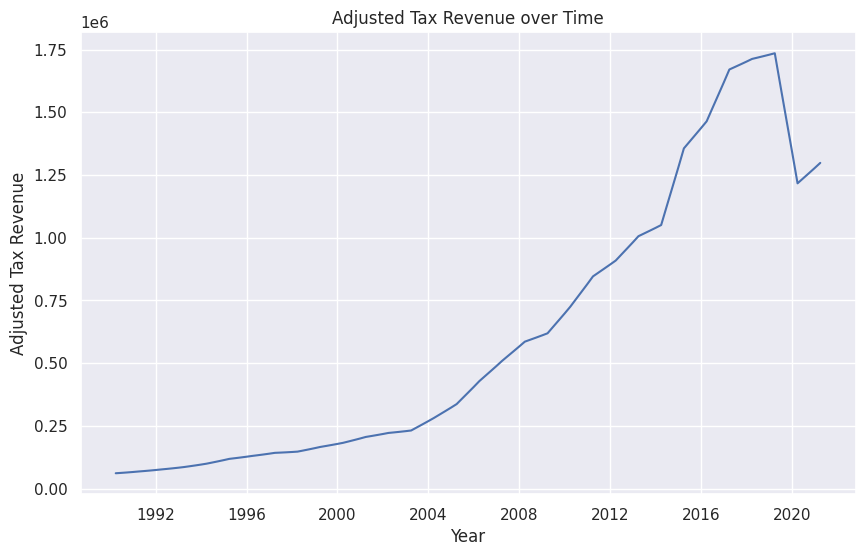

In [12]:
# Plot the adjusted tax revenue data
plt.figure(figsize=(10, 6))
plt.plot(adjusted_data.index, new_data['Tax_Revenue'])
plt.xlabel('Year')
plt.ylabel('Adjusted Tax Revenue')
plt.title('Adjusted Tax Revenue over Time')
plt.grid(True)
plt.show()

In [13]:
#Data stationary checking

test_result = adfuller(new_data['Tax_Revenue'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Tax_revenue):
    result=adfuller(Tax_revenue)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(new_data['Tax_Revenue'])

ADF Test Statistic : -1.1451080638755895
p-value : 0.6967524059718726
#Lags Used : 9
Number of Observations Used : 115
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


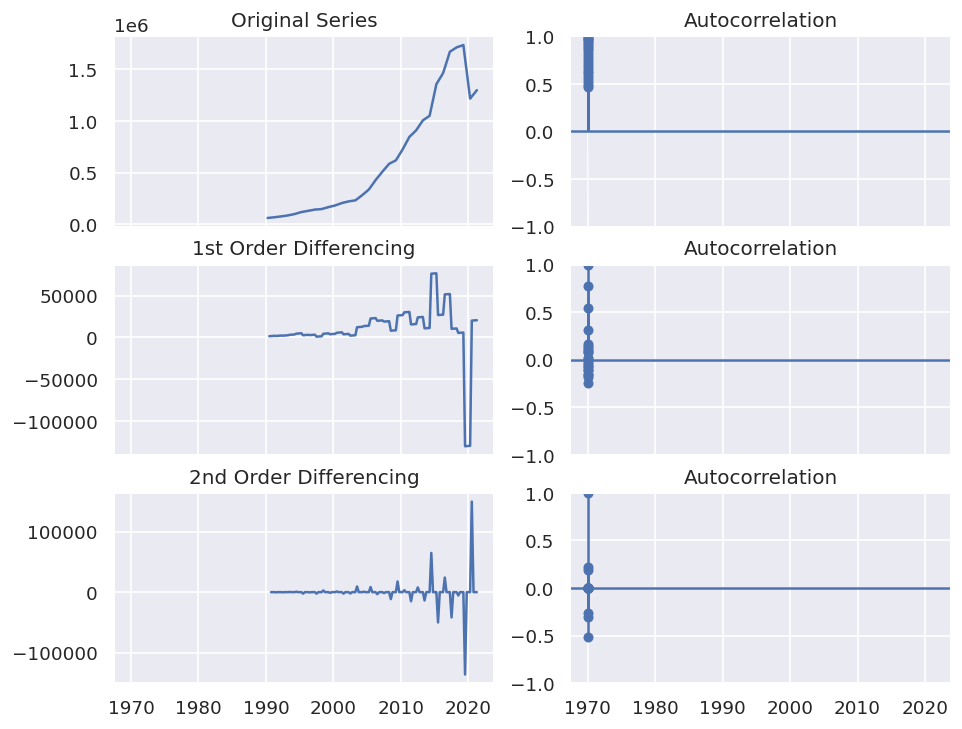

In [14]:
#Since p-value(0.45) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(new_data.Tax_Revenue); axes[0, 0].set_title('Original Series')
plot_acf(new_data.Tax_Revenue, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(new_data.Tax_Revenue.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(new_data.Tax_Revenue.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(new_data.Tax_Revenue.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(new_data.Tax_Revenue.diff().diff().dropna(), ax=axes[2, 1])

plt.show()



**MODEL 01 - ARIMA MODEL **

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [18]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(new_data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=new_data.index)


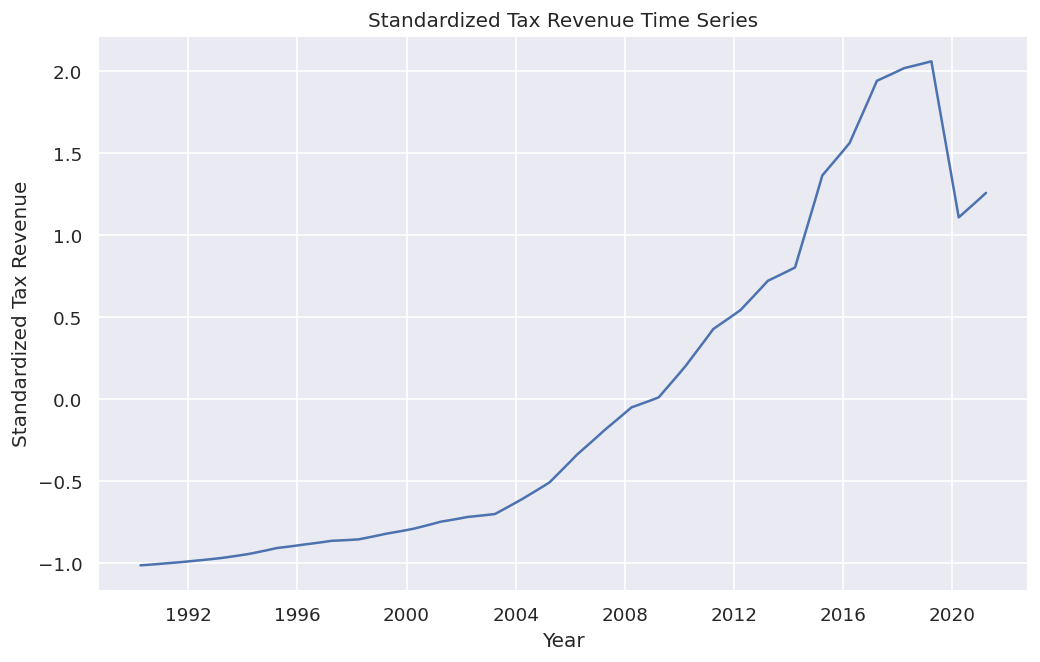

In [19]:
# Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(data_scaled)
plt.title('Standardized Tax Revenue Time Series')
plt.xlabel('Year')
plt.ylabel('Standardized Tax Revenue')
plt.show()

In [20]:
# Train-test split
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]



In [21]:
train.head()

,Tax Revenue
Year,
1990-03-31,-1.014753
1990-06-30,-1.011987
1990-09-30,-1.008937
1990-12-31,-1.005601
1991-03-31,-1.001979


In [22]:

# ARIMA model with specified parameters p=2, d=1, q=2
p = 2
d = 1
q = 2

# Bagging ARIMA models
n_models = 10  # Number of models in the ensemble
forecasts = []

for _ in range(n_models):
    # Bootstrap resampling
    train_sample = resample(train, replace=True, n_samples=len(train))
    train_sample_diff = train_sample.diff().dropna()

    # Train an ARIMA model
    model = ARIMA(train_sample_diff, order=(p, d, q))
    model_fit = model.fit()

    # Forecast the next len(test) time steps
    forecast = model_fit.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean.values

    forecast = model_fit.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean.values

    forecasts.append(forecast_mean)

# Aggregate the forecasts from all models
bagged_forecast = np.mean(forecasts, axis=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [23]:
# Calculate RMSE on test set
rmse = np.sqrt(mean_squared_error(test['Tax Revenue'], bagged_forecast[:len(test)]))
print('RMSE:', rmse)

# Calculate Mean Squared Error (MSE)
mse_a = mean_squared_error(test['Tax Revenue'], bagged_forecast[:len(test)])
print("Mean Squared Error:", mse_a)

RMSE: 1.6889056340288857
Mean Squared Error: 2.8524022406545124


**MODEL 02 - GARCH MODEL **

In [ ]:
!pip install arch

In [24]:
# Split the dataset into training and test sets
train_es = new_data.iloc[:-5]
test_es = new_data.iloc[-5:]

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_percentage_error
import arch
import numpy as np

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test sets
train_scaled_grch = scaler.fit_transform(train_es.values.reshape(-1, 1)).flatten()
test_scaled_grch = scaler.transform(test_es.values.reshape(-1, 1)).flatten()

# Number of models in the ensemble
n_models = 10

# Create an empty list to store forecasts from each model
forecasts_grch = []

for _ in range(n_models):
    # Bootstrap resampling for training
    train_sample = resample(train_scaled_grch, replace=True, n_samples=len(train_scaled_grch))

    # Create the GARCH model
    model_grch = arch.arch_model(train_sample, vol='Garch')

    # Fit the GARCH model on the resampled data
    model_fit_grch = model_grch.fit()

    # Forecast using the GARCH model
    forecast = model_fit_grch.forecast(start=len(test_scaled_grch))

    # Convert the forecasted values to an array
    forecast_values_grch = forecast.mean.values[-len(test_scaled_grch):]

    forecasts_grch.append(forecast_values_grch)

# Aggregate the forecasts from all models
bagged_forecast_grch = np.mean(forecasts_grch, axis=0)

# Calculate MAPE
mape_grch = mean_absolute_percentage_error(test_scaled_grch, bagged_forecast_grch) * 100

# Print the MAPE
print("MAPE:", mape_grch)

# Calculate MSE
mse_grch = mean_squared_error(test_scaled_grch, bagged_forecast_grch)

# Print the MSE
print("MSE:", mse_grch)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 348.86115398383754
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.78786843951184
Iteration:      3,   Func. Count:     20,   Neg. LLF: 179.6663202517318
Iteration:      4,   Func. Count:     26,   Neg. LLF: 182.22399132696182
Iteration:      5,   Func. Count:     33,   Neg. LLF: 179.47574496683143
Iteration:      6,   Func. Count:     38,   Neg. LLF: 179.47573565136344
Iteration:      7,   Func. Count:     42,   Neg. LLF: 179.47573565142775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 179.47573565136344
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 67773776.5458098
Iteration:      2,   Func. Count:     13,   Neg. LLF: 188.28589112379217
Iteration:      3,   Func. Count:     20,   Neg. LLF: 197.84848260645194
Iteration:      4,   Func. Count:     27,   Neg. LLF: 173.5435293

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alter

Iteration:      1,   Func. Count:      6,   Neg. LLF: 273837636.03924465
Iteration:      2,   Func. Count:     13,   Neg. LLF: 198.94534926189075
Iteration:      3,   Func. Count:     21,   Neg. LLF: 181.11944137057455
Iteration:      4,   Func. Count:     28,   Neg. LLF: 177.871705329315
Iteration:      5,   Func. Count:     33,   Neg. LLF: 177.86603971951962
Iteration:      6,   Func. Count:     38,   Neg. LLF: 177.8657129407655
Iteration:      7,   Func. Count:     43,   Neg. LLF: 177.8656824833683
Iteration:      8,   Func. Count:     48,   Neg. LLF: 177.86567903053196
Iteration:      9,   Func. Count:     52,   Neg. LLF: 177.86567903047307
Optimization terminated successfully    (Exit mode 0)
            Current function value: 177.86567903053196
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 64266011.00113434
Iteration:      2,   Func. Count:     14,   Neg. LLF: 163.786097019

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


Iteration:      5,   Func. Count:     34,   Neg. LLF: 168.40152577666242
Iteration:      6,   Func. Count:     40,   Neg. LLF: 168.14543470718064
Iteration:      7,   Func. Count:     46,   Neg. LLF: 168.10547714886013
Iteration:      8,   Func. Count:     52,   Neg. LLF: 168.08991013157527
Iteration:      9,   Func. Count:     58,   Neg. LLF: 168.07837906837185
Iteration:     10,   Func. Count:     64,   Neg. LLF: 167.9257739811762
Iteration:     11,   Func. Count:     70,   Neg. LLF: 199.10207206640465
Iteration:     12,   Func. Count:     77,   Neg. LLF: 167.9433793005877
Iteration:     13,   Func. Count:     83,   Neg. LLF: 167.9753380043926
Iteration:     14,   Func. Count:     89,   Neg. LLF: 167.83088546749735
Iteration:     15,   Func. Count:     95,   Neg. LLF: 167.7966096998319
Iteration:     16,   Func. Count:    100,   Neg. LLF: 167.79370055566028
Iteration:     17,   Func. Count:    105,   Neg. LLF: 167.7934979789534
Iteration:     18,   Func. Count:    110,   Neg. LLF: 16

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alter

Iteration:      1,   Func. Count:      6,   Neg. LLF: 190.1707600378208
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3226.5573224208647
Iteration:      3,   Func. Count:     21,   Neg. LLF: 163.02171522461222
Iteration:      4,   Func. Count:     27,   Neg. LLF: 163.03762525803913
Iteration:      5,   Func. Count:     33,   Neg. LLF: 163.01163435711192
Iteration:      6,   Func. Count:     37,   Neg. LLF: 163.01163435703677
Optimization terminated successfully    (Exit mode 0)
            Current function value: 163.01163435711192
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 201.30050154612604
Iteration:      2,   Func. Count:     14,   Neg. LLF: 178.10651450625824
Iteration:      3,   Func. Count:     20,   Neg. LLF: 178.14443134589197
Iteration:      4,   Func. Count:     26,   Neg. LLF: 177.92828251208397
Iteration:      5,   Func. Count:     31,   Neg. LLF: 177.89543

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


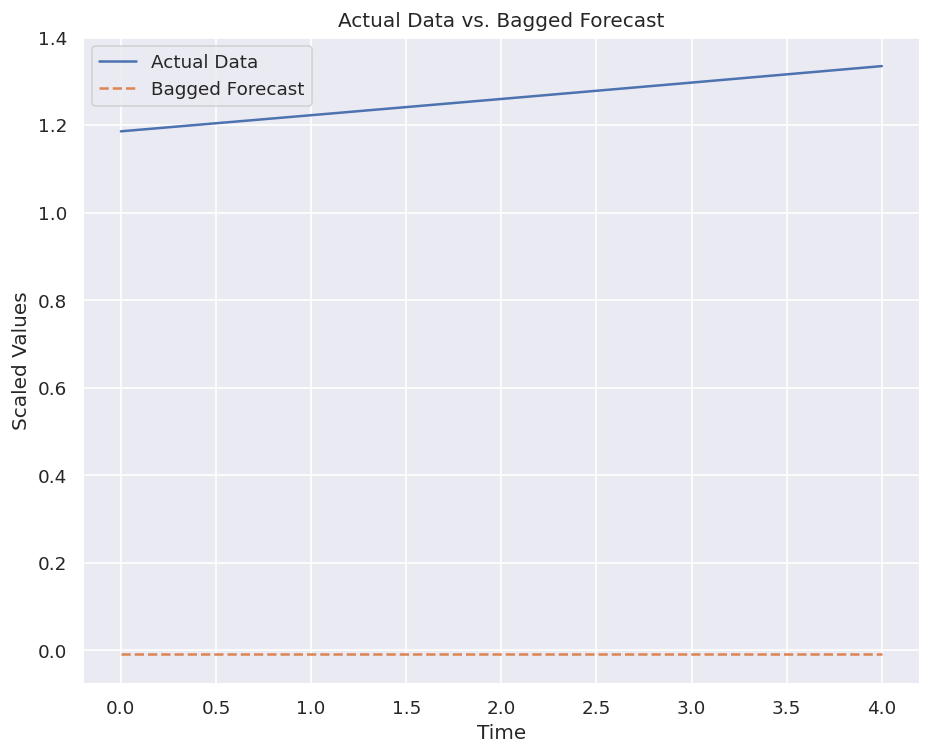

In [25]:
import matplotlib.pyplot as plt

# Plot the original test data
plt.plot(test_scaled_grch, label="Actual Data")

# Plot the bagged forecast
plt.plot(bagged_forecast_grch, label="Bagged Forecast", linestyle="--")

plt.xlabel("Time")
plt.ylabel("Scaled Values")
plt.title("Actual Data vs. Bagged Forecast")
plt.legend()
plt.show()


**MODEL 03 - EXPONENTIAL SMOOTHING **

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [25]:
# Create and fit the Holt-Winters seasonal exponential smoothing model
es_model = ExponentialSmoothing(train_es['Tax_Revenue'], seasonal='add', seasonal_periods=12)
es_fitted_model = es_model.fit()

# Perform forecasting for the next 5 years
forecast_horizon = 60  # 5 years with monthly data
es_forecast = es_fitted_model.forecast(forecast_horizon)

# Standard scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_es[['Tax_Revenue']])
test_scaled = scaler.transform(test_es[['Tax_Revenue']])

# Create and fit the BaggingRegressor
bagging_model = BaggingRegressor(n_estimators=10, random_state=0)
bagging_model.fit(np.arange(len(train_es)).reshape(-1, 1), train_scaled.ravel())  # Reshape to 1D array

# Predict using the bagging model
bagging_forecast_scaled = bagging_model.predict(np.arange(len(train_es), len(train_es) + forecast_horizon).reshape(-1, 1))

# Create and fit the Holt-Winters seasonal exponential smoothing model with scaled data
es_scaled_model = ExponentialSmoothing(train_scaled, seasonal='add', seasonal_periods=12)
es_scaled_fitted_model = es_scaled_model.fit()

# Perform forecasting for the next 5 years with scaled model
es_scaled_forecast = es_scaled_fitted_model.forecast(forecast_horizon)

# Calculate MSE for the scaled model
mse_scaled = mean_squared_error(test_scaled, es_scaled_forecast[:len(test_scaled)])
print("MSE (Scaled Holt-Winters):", mse_scaled)

# Print the forecasted values and MSE
print("Forecasted Values (Holt-Winters):")
print(es_forecast)

MSE (Scaled Holt-Winters): 0.036774412605311106
Forecasted Values (Holt-Winters):
2020-03-31    1.346742e+06
2020-06-30    1.345810e+06
2020-09-30    1.344814e+06
2020-12-31    1.343745e+06
2021-03-31    1.342593e+06
2021-06-30    1.343572e+06
2021-09-30    1.346259e+06
2021-12-31    1.346462e+06
2022-03-31    1.346803e+06
2022-06-30    1.346666e+06
2022-09-30    1.346682e+06
2022-12-31    1.346750e+06
2023-03-31    1.346742e+06
2023-06-30    1.345810e+06
2023-09-30    1.344814e+06
2023-12-31    1.343745e+06
2024-03-31    1.342593e+06
2024-06-30    1.343572e+06
2024-09-30    1.346259e+06
2024-12-31    1.346462e+06
2025-03-31    1.346803e+06
2025-06-30    1.346666e+06
2025-09-30    1.346682e+06
2025-12-31    1.346750e+06
2026-03-31    1.346742e+06
2026-06-30    1.345810e+06
2026-09-30    1.344814e+06
2026-12-31    1.343745e+06
2027-03-31    1.342593e+06
2027-06-30    1.343572e+06
2027-09-30    1.346259e+06
2027-12-31    1.346462e+06
2028-03-31    1.346803e+06
2028-06-30    1.346666e+06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


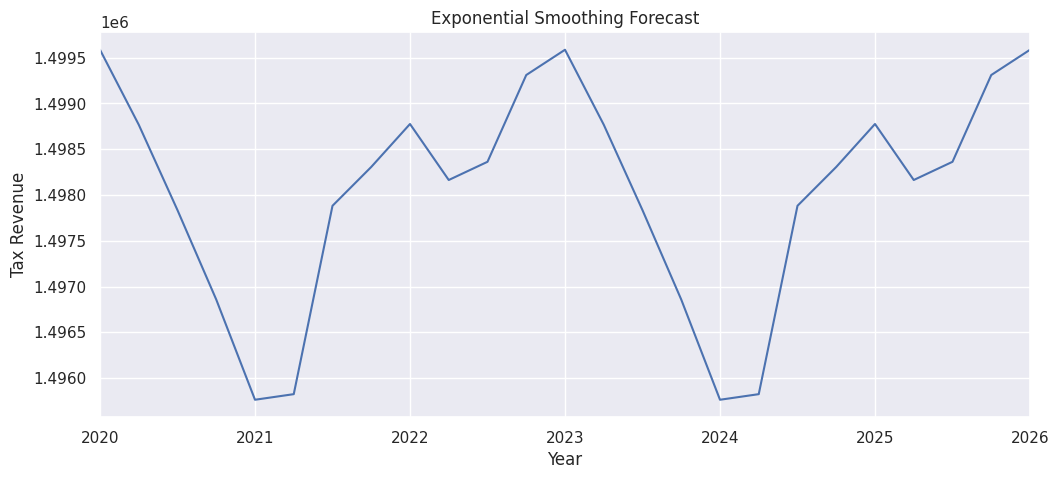

In [32]:
# Plot the forecast
plt.figure(figsize=(12, 5), dpi=100)
es_forecast.plot()
plt.xlabel('Year')
plt.ylabel('Tax Revenue')
plt.title('Exponential Smoothing Forecast')
plt.show()

**MODEL 04 - LSTM **

In [92]:
lstm_data = pd.read_csv('/content/cbsl_tot_tax.csv')

# Remove unnecessary columns
lstm_data = lstm_data[['Year', 'Tax Revenue']]

#getting the mean of tax revenue ammount and fill it to null, if theres any
lstm_data["Tax Revenue"] = lstm_data["Tax Revenue"].astype("float64")
m=round(lstm_data["Tax Revenue"].mean(),2)
lstm_data["Tax Revenue"].fillna(m,inplace=True)

#Convert the "Year" column to datetime format
lstm_data[ 'Year'] = pd.to_datetime(lstm_data[ 'Year'], format='%Y')

#Set the "Year" column as the index
lstm_data.set_index('Year', inplace=True)

lstm_data.head()

,Total Revenue
Year,
1990-01-01,67964.0
1991-01-01,76179.0
1992-01-01,85781.0
1993-01-01,98339.0
1994-01-01,110038.0


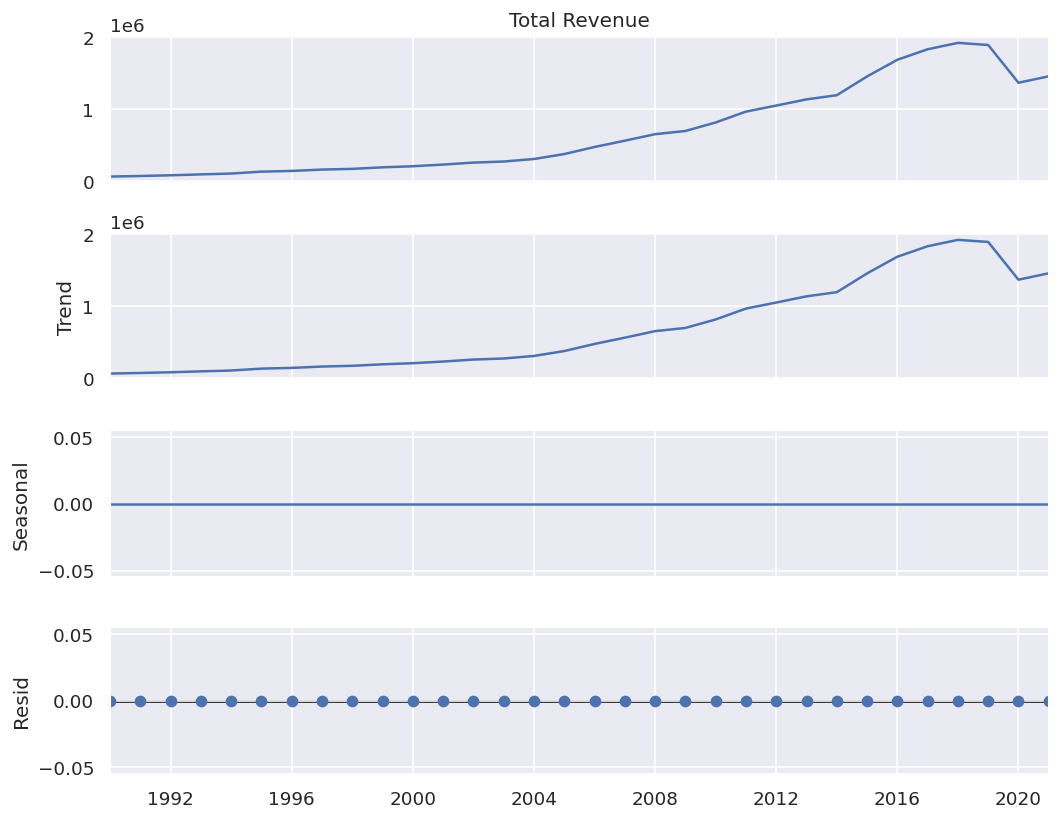

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(lstm_data['Tax Revenue'])
results.plot();

In [94]:
len(lstm_data)

32

In [95]:
#dividing training and testing set
train_rnn = lstm_data.iloc[:25]
test_rnn = lstm_data.iloc[25:]

In [96]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [97]:
lstm_data.head(),lstm_data.tail()

(            Total Revenue
 Year                     
 1990-01-01        67964.0
 1991-01-01        76179.0
 1992-01-01        85781.0
 1993-01-01        98339.0
 1994-01-01       110038.0,
             Total Revenue
 Year                     
 2017-01-01      1831531.0
 2018-01-01      1919973.0
 2019-01-01      1890899.0
 2020-01-01      1367960.0
 2021-01-01      1457071.0)

In [98]:
scaler.fit(train_rnn)
scaled_train = scaler.transform(train_rnn)
scaled_test = scaler.transform(test_rnn)

In [100]:
# Timeseries generator
n_input = 12  # You can adjust this as needed
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# Create LSTM model
rnn_model = Sequential()
rnn_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
rnn_model.fit(generator, epochs=50)

# Prepare the last training batch for prediction
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

# Predict scaled values
test_predictions_scaled = []

for i in range(len(test_rnn)):
    current_pred_scaled = rnn_model.predict(last_train_batch)[0]
    test_predictions_scaled.append(current_pred_scaled)
    last_train_batch = np.append(last_train_batch[:, 1:, :], [[current_pred_scaled]], axis=1)

# Calculate Mean Squared Error (MSE) in scaled values
mse_scaled = mean_squared_error(scaled_test, test_predictions_scaled)
print("Mean Squared Error (Scaled):", mse_scaled)

Epoch 1/50
13/13 [==============================] - 3s 15ms/step - loss: 0.2905
Epoch 2/50
13/13 [==============================] - 0s 19ms/step - loss: 0.1486
Epoch 3/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0389
Epoch 4/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0185
Epoch 5/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0157
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0135
Epoch 7/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0097
Epoch 8/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0088
Epoch 9/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 10/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0070
Epoch 11/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0068
Epoch 12/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 13/50
13/13 [=====================

In [1]:
# Plot scaled predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(scaled_test, label='Actual')
plt.plot(test_predictions_scaled, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Scaled Tax Revenue')
plt.title('Actual vs Predicted Tax Revenue (Scaled)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined